# Training to align Taps

The idea is to train a kernel to detect beats.  It is assumed that there is typically some sort of percussion on the beat, which the network can pick up on.

Here we only test a simple binary classification network, that predicts whether a beat is at a certain place or not.

In [13]:
%matplotlib notebook
import os.path
import pickle
import numpy as np
import random
import matplotlib.pyplot as plt
plt.ion()
from importlib import reload

In [14]:
# load local code
import sys
sys.path.append('src')
import nf_train.data as nfd
reload(nfd)
None

In [15]:
# initialize data source
data_dir = nfd.DataDir('../nf_data/run2/')
print(f"Data contains {len(data_dir.processed)} songs.")
print(f"{len(data_dir.failed)} songs failed to process.")
print(f"One second contains {data_dir.params['rate']} samples.")
print(f"One sample has {data_dir.params['n_filters']} features.")

Data contains 43 songs.
0 songs failed to process.
One second contains 100.0 samples.
One sample has 30 features.


In [16]:
bpms = sorted([(song['info']['bpm'], song['info']['title']) for song in data_dir.processed])
bpms

[(90.0, 'Mirage a Trois'),
 (115.0, "A List of Instructions for When I'm Human"),
 (123.0, 'Canis Lupus'),
 (125.0, 'Another Chance (Original Mix)'),
 (125.0, 'Fuego (Julian Jeweil Remix)'),
 (125.0, 'Going Down (Original Mix)'),
 (125.0, 'Humano (Victor Ruiz Remix)'),
 (125.0, 'Rave (Original Mix)'),
 (125.0, 'Unconditional Beauty (Original Mix)'),
 (126.0, 'Perpendicular (Original Mix)'),
 (126.0, 'Robinson Jr.'),
 (126.0, 'X-Pollination (Original Mix)'),
 (127.0, 'Edging Forward (Original Mix)'),
 (127.0, 'Raita Yksi (Original Mix)'),
 (128.0, 'Acid Trip (Original Mix)'),
 (128.0, 'Homeless (Sebastian Groth Power Edit)'),
 (128.0, 'Iyewaye (Original Mix)'),
 (128.0, 'Knights & Bishops (Original Mix)'),
 (128.0, 'Neuroluminescence'),
 (128.0, 'Target Line featuring Vril (Original Mix)'),
 (128.0, 'Trigger'),
 (129.0, 'Nausea (Trilingo Remix)'),
 (130.0, 'Cydonia (Original Mix)'),
 (130.0, 'Molestrial (Original Mix)'),
 (131.0, 'Fumifugium (Original Mix)'),
 (131.0, 'Hamartia (Origina

In [17]:
data = data_dir.get_file('8116012_Zoombai_Warriors_Surfing_on_a_Small_Chapati_Sound_in_the_East_of_Parvati_Megamix.pickle')
data = data_dir.get_file('9397943_LSD_Original_Mix.pickle')
target = np.array(data.beat_grid)[:,None]
hist = np.array(data.hist)
joined_data = np.hstack((hist, target))
#joined_data = np.clip(joined_data, 0, 1)

<IPython.core.display.Javascript object>


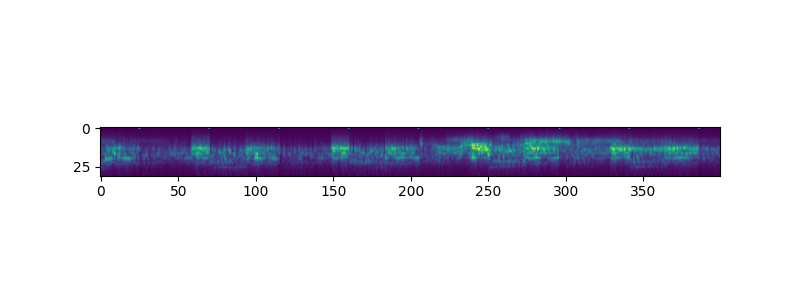

In [18]:
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
secs = 30 * 5
span = 4
span = span * 100
x = secs * 100
ax.imshow(np.flip(joined_data[x:x+span].T, axis=0), aspect=1)

In [19]:
beats = data.beat_indices
samples = data.get_samples(beats, None, offset=-10, length=31)
print(len(samples))
samples[0].info

712


{'title': 'LSD (Original Mix)',
 'loc': '/home/felix/nextcloud/Music/beatport/9397943_LSD_Original_Mix.mp3',
 'bpm': 133.0,
 'offset': 1231}

<IPython.core.display.Javascript object>


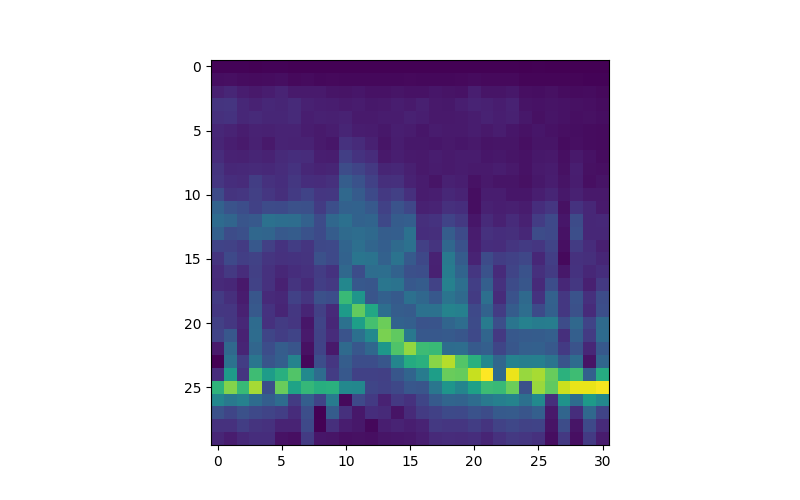

1.874179482460022


In [20]:
sample = samples[420]
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.imshow(np.flip(np.array(sample.hist).T, axis=0), aspect=1)
print(np.max(sample.hist))

## Generate Training Data



In [21]:
def get_neg_indices(pos_indices, k=1):
    offsets = np.random.choice([-1, 1, -2, 2, -3, 3],
                               p=[0.3, 0.3, 0.15, 0.15, 0.05, 0.05],
                               size=(k, len(pos_indices)))
    res = []
    for ofs in offsets:
        for i, of in zip(pos_indices, ofs):
            res.append(i + of)
    return res

def get_tr_va_data(data, k, offset, length, ratio):
    pos_indices = data.beat_indices
    pos_samples = data.get_samples(pos_indices, 1, offset=offset, length=length)
    random.shuffle(pos_samples)
    neg_indices = get_neg_indices(pos_indices, k=k)
    neg_samples = data.get_samples(neg_indices, 0, offset=offset, length=length)
    random.shuffle(neg_samples)
    print(f"samples: {len(pos_samples)} pos; {len(neg_samples)} neg")
    tr_p_set_size = round(len(pos_samples) * ratio)
    tr_n_set_size = round(len(neg_samples) * ratio)
    tr_p_samples = pos_samples[:tr_p_set_size]
    tr_n_samples = neg_samples[:tr_n_set_size]
    tr_samples = tr_p_samples + tr_n_samples
    # validation
    va_p_samples = pos_samples[tr_p_set_size:]
    va_n_samples = neg_samples[tr_n_set_size:]
    va_samples = va_p_samples + va_n_samples
    tr_samples = [{'hist': s.hist, 'label': s.label} for s in tr_samples]
    va_samples = [{'hist': s.hist, 'label': s.label} for s in va_samples]
    return tr_samples, va_samples

def tr_va_from_files(files, k, offset, length, ratio):
    tr_samples, va_samples = [], []
    for file in files:
        data = data_dir.get_file(file)
        t, v = get_tr_va_data(data, k, offset, length, ratio)
        tr_samples.extend(t)
        va_samples.extend(v)
    return tr_samples, va_samples        

## Neural Network

In [22]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm.notebook import tqdm

In [23]:
class SimpleFF(nn.Module):
    def __init__(self,
                 t: int,
                 d: int):
        super(SimpleFF, self).__init__()
        self.t = t
        self.d = d
        self.ff = nn.Linear(t * d, 1)
        
    def forward(self, inputs):
        out = inputs
        out = self.ff(out)
        out = torch.sigmoid(out)
        return out
    
    def save_to_pickle(self, filename):
        data = {}
        data['weights'] = self.ff.weight.detach().numpy().reshape((self.t, self.d)).tolist()
        data['bias'] = self.ff.bias.detach().numpy()[0]
        with open(filename, 'wb') as f:
            pickle.dump(data, f)

In [24]:
def validate_model(model, data_loader):
    model.eval()
    correct = 0
    for sample in tqdm(data_loader):
        x = torch.tensor(sample['hist'], dtype=torch.float).flatten()
        out = model(x)
        beat = out.data[0] > 0.5
        correct += beat == (sample['label'] == 1)
    v = float(correct)/len(data_loader)
    return v

def train(model, tr_set, va_set, epochs=10):
    optimizer = torch.optim.Adam(model.parameters())
    tr_loader = DataLoader(tr_set, shuffle=True)
    va_loader = DataLoader(va_set, shuffle=True)
    
    for epoch in tqdm(range(epochs)):
        model.train()
        for sample in tqdm(tr_loader):
            x = torch.tensor(sample['hist'], dtype=torch.float).flatten()
            y = sample['label']
            out = model(x)
            #print(f"out: {out}")
            loss = F.mse_loss(out, torch.tensor([y], dtype=torch.float))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        tr_acc = validate_model(model, tr_loader)
        va_acc = validate_model(model, va_loader)
        print(f"Acc tr: {tr_acc:.02f}; va: {va_acc:.02f}")

In [25]:
t_len = 9
tr_samples, va_samples = tr_va_from_files(
    [
    '9397943_LSD_Original_Mix.pickle',
    '5799420_Rave_Original_Mix.pickle',
    '8498819_Raita_Yksi_Original_Mix.pickle',
    '9928622_Target_Line_featuring_Vril_Original_Mix.pickle',
    '7811712_Edging_Forward_Original_Mix.pickle',
    '9006939_Acid_Trip_Original_Mix.pickle',
    '6450638_Iyewaye_Original_Mix.pickle',
    '7600824_Tripical_Moon_Original_Mix.pickle',
    '9928484_Orchid_Original_Mix.pickle',
    '3887937_Pistolero_Astrix_Remix.pickle',
    '10310700_Fucking_Dimensions_Original_Mix.pickle',
    '8483511_Egypt_Stage_Original_Mix.pickle',
    #'10 - Bratenschneider - Trigger.pickle',
    '10924655_Take_Kurie__Original_Mix__Original_Mix.pickle',
    #'06 - Nicorus - Canis Lupus.pickle',
    #'8013109_Daydream_Original_Mix.pickle',
    '8602606_Here_We_Go_Again_2016_Pro_Mix.pickle',
    ], 2, -3, t_len, 0.7)

samples: 712 pos; 1425 neg
samples: 846 pos; 1691 neg
samples: 972 pos; 1944 neg
samples: 1036 pos; 2072 neg
samples: 885 pos; 1769 neg
samples: 1176 pos; 2352 neg
samples: 982 pos; 1964 neg
samples: 1000 pos; 2000 neg
samples: 1097 pos; 2194 neg
samples: 1024 pos; 2049 neg
samples: 1048 pos; 2096 neg
samples: 783 pos; 1567 neg
samples: 912 pos; 1824 neg
samples: 536 pos; 1073 neg


In [26]:
model = SimpleFF(t_len, 30)
train(model, tr_samples, va_samples, epochs=1)


Acc tr: 0.83; va: 0.83



<IPython.core.display.Javascript object>


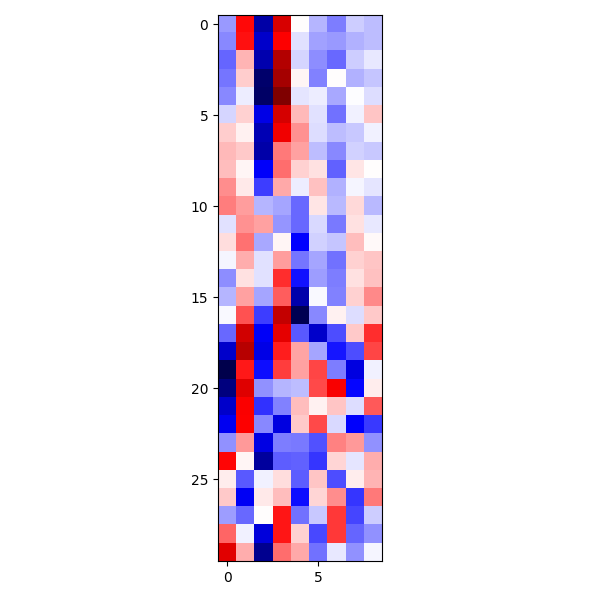

In [243]:
w = model.ff.weight.detach().numpy().reshape((t_len, 30))
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.imshow(np.flip(w.T, axis=0), cmap='seismic')
fig.tight_layout()

In [252]:
model.save_to_pickle("model.pickle")

In [249]:
# TODO: normalize values.  Add noise on input.  Try L1 reg. .. batching!
# also I should save the parameters at data generation, carry them through here and 
# save them in the model.pickle to load later